## Parse model config yaml file

/usr/local/lib/python3.9/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


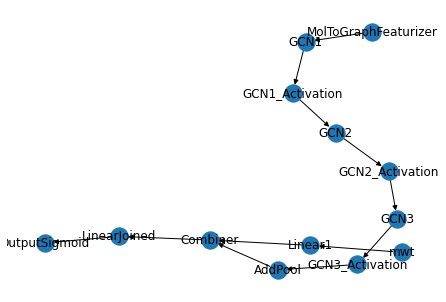

In [2]:
import networkx as nx
import yaml

from app.features.model.schema.configs import ModelConfig

config = """name: GNNExample

dataset:
  name: test_dataset_2
  target_column: tpsa
  feature_columns:
    - smiles
    - mwt

featurizers:
  - name: MolToGraphFeaturizer
    type: app.features.model.featurizers.MoleculeFeaturizer
    input:
      - smiles
    args:
      allow_unknown: false
      sym_bond_list: true
      per_atom_fragmentation: false

layers:

  # Start fst branch (from featurizer)
  - name: GCN1
    type: torch_geometric.nn.GCNConv
    args:
      in_channels: 30
      out_channels: 64
    input: MolToGraphFeaturizer

  - name: GCN1_Activation
    type: torch.nn.ReLU
    input: GCN1

  - name: GCN2 
    type: torch_geometric.nn.GCNConv
    input: GCN1_Activation
    args:
      in_channels: 64
      out_channels: 64

  - name: GCN2_Activation
    type: torch.nn.ReLU
    input: GCN2

  - name: GCN3
    type: torch_geometric.nn.GCNConv
    input: GCN2_Activation
    args:
      in_channels: 64
      out_channels: 64

  - name: GCN3_Activation
    type: torch.nn.ReLU
    input: GCN3

  - name: AddPool
    type: app.features.model.layers.GlobalPooling
    input: GCN3_Activation
    args:
      aggr: 'sum'
  # End of fst branch

  # Second branch would simply be linear layers in mwt
  - name: Linear1
    type: torch.nn.Linear
    args:
      in_features: 1
      out_features: 10
    input: mwt

  - name: Combiner
    type: app.features.model.layers.Concat
    input: ['AddPool', 'Linear1']

  - name: LinearJoined
    type: torch.nn.Linear
    input: Combiner
    args:
      in_features: 74
      out_features: 1

  - name: OutputSigmoid
    type: torch.nn.Sigmoid
    input: LinearJoined
"""

model = ModelConfig.from_yaml(config)

nx.draw(model.make_graph(), with_labels=True)

In [22]:
import torch_geometric.nn as geom_nn
from torch.nn import ReLU, Sigmoid
from app.features.model.layers import GlobalPooling
from app.features.model.layers import Concat

edge_index_classes = ( geom_nn.MessagePassing )
pooling_classes = ( GlobalPooling )
activations = (ReLU, Sigmoid)

def is_message_passing(layer):
    """ x = layer(x, edge_index) """
    return isinstance(layer, geom_nn.MessagePassing)

def is_graph_pooling(layer):
    """ x = layer(x, batch) """
    return isinstance(layer, pooling_classes)

def is_concat_layer(layer):
    return isinstance(layer, Concat)

def is_graph_activation(layer, layers_dict, previous):
    """
    takes the a dictionary with nn.Modules and the keys of
    previous layers, checking if 
    """
    if not isinstance(layer, activations):
        return False
    for name in previous:
        if is_message_passing(layers_dict[name]) or is_graph_pooling(layers_dict[name]):
            return True
    return False


### Input Example

In [40]:
from torch_geometric.data import Data
import torch

x = torch.ones(3, 30, dtype=torch.float)
edge_index = torch.tensor([[0, 1, 1, 2], [1, 0, 2, 1]], dtype=torch.long)
mwt = torch.tensor([[230.]], dtype=torch.float)

dataset_input = {
    'MolToGraphFeaturizer': Data(x=x, edge_index=edge_index, batch=None),
    'mwt': mwt
}
dataset_input

{'MolToGraphFeaturizer': Data(x=[3, 30], edge_index=[2, 4]),
 'mwt': tensor([[230.]])}

### Custom Model

In [41]:
# Implement module forward
from typing import Dict, Union, List
import torch
import torch.nn
import torch_geometric.nn as geom_nn
from torch_geometric.data import Data

CustomDatasetIn = Dict[str, Union[torch.Tensor, Data]]

def if_string_make_list(str_or_list: Union[str, List[str]]) -> List[str]:
    if isinstance(str_or_list, str):
        return [str_or_list]
    return str_or_list

class CustomModel(torch.nn.Module):

    def __init__(self, config: ModelConfig):
        super().__init__()
        
        self.config = config

        layers_dict = {}
        for layer in config.layers:
            layers_dict[layer.name] = layer.create()

        self.layers = torch.nn.ModuleDict(layers_dict)

        self.layer_configs = {
            l.name: l for l in config.layers
        }

        self.graph = config.make_graph()
        self.topo_sorting = list(nx.topological_sort(self.graph))
    
    def forward(self, input_: CustomDatasetIn):
        storage = input_.copy()

        for index, node_name in enumerate(self.topo_sorting):
            if not node_name in self.layers:
                continue
            layer_name = node_name
            layer = self.layers[layer_name]
            layer_config = self.layer_configs[layer_name]
            previous_layers = [p_layer for p_layer, c_layer in self.graph.in_edges(layer_name)]
            next_layers = [n_layer for c_layer, n_layer in self.graph.out_edges(layer_name)]
            inputs = if_string_make_list(layer_config.input)
            print(f'Layer:       {layer}')
            print(f'LayerConfig: {layer_config}')
            print(f'Previous:    {previous_layers}')
            print(f'Next:        {next_layers}')
            print(f'Inputs:      {inputs}')
            # Step 2
            # Transform and preprocess the input and output based on the previous
            # and next layers.
            
            if is_message_passing(layer):
                assert len(inputs) == 1, f"Length of a gnn layer's inputs should be at most 1. inputs = {inputs}"
                input_source = inputs[0]
                x, edge_index = storage[input_source].x, storage[input_source].edge_index
                print('Input:')
                print(x)
                print(edge_index)
                x, edge_index = layer(x=x, edge_index=edge_index), edge_index
                storage[layer_name] = Data(x=x, edge_index=edge_index)
                print('Output:')
                print(storage[layer_name])
            # 2.2   - if its an pooling layer it always have just one input
            #         and the input is composed by x (node_features) from the last layer
            #         and the batch that comes with the data object
            elif is_graph_pooling(layer):
                assert len(inputs) == 1, f"Length of a gnn layer's inputs should be at most 1. inputs = {inputs}"
                input_source = inputs[0]
                x, edge_index, batch = storage[input_source].x, storage[input_source].edge_index, storage[input_source].batch
                storage[layer_name] = layer(x=x, batch=batch)
                print('Input:')
                print(x)
                print(batch)
                print('Output:')
                print(storage[layer_name])
            # 2.3   - if its an activation or a mlp/normal layer we need to check the
            #         previous layers to make sure that the input is in t;he correct format
            #         and check the next layers to format the output
            elif is_graph_activation(layer, self.layers, previous_layers):
                assert len(inputs) == 1, f"Length of a activation layer's inputs should be at most 1. inputs = {inputs}"
                src = inputs[0]
                if isinstance(storage[src], Data):
                    x, edge_index = storage[src].x, storage[src].edge_index
                    storage[layer_name] = Data(x=layer(x), edge_index=edge_index)
                else:
                    x = storage[src]
                    storage[layer_name] = layer(x)
                    print('Inputs:')
                print(input_values)
                print('Output')
                print(storage[layer_name])
            else: # elif is_linear_or_activation(layer) or is_concat(layer) :
                input_values = [ 
                    storage[input] if isinstance(storage[input], Data) else
                    storage[input]
                    for input in inputs
                ]
                print('Inputs:')
                print(input_values)
                for val in input_values:
                    print(val.size())
                print('Output')
                storage[layer_name] = layer(*input_values)
                print(storage[layer_name])
                
custom_model = CustomModel(model)
custom_model.forward(dataset_input)

Layer:       GCNConv(30, 64)
LayerConfig: name='GCN1' input='MolToGraphFeaturizer' type='torch_geometric.nn.GCNConv' args=TorchgeometricgcnconvArgs(in_channels=30, out_channels=64)
Previous:    ['MolToGraphFeaturizer']
Next:        ['GCN1_Activation']
Inputs:      ['MolToGraphFeaturizer']
Input:
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[0, 1, 1, 2],
        [1, 0, 2, 1]])
Output:
Data(x=[3, 64], edge_index=[2, 4])
Layer:       Linear(in_features=1, out_features=10, bias=True)
LayerConfig: name='Linear1' input='mwt' type='torch.nn.Linear' args=TorchlinearArgs(in_features=1, out_features=10)
Previous:    ['mwt

RuntimeError: torch.cat(): Sizes of tensors must match except in dimension 0. Got 64 and 10 in dimension 1 (The offending index is 1)

In [135]:
# Implement module forward
from typing import Dict, Union
import torch
import torch.nn
import torch_geometric.nn as geom_nn
from torch_geometric.data import Data

CustomDatasetIn = Dict[str, Union[torch.Tensor, Data]]

def if_string_make_list(str_or_list: Union[str, List[str]]) -> List[str]:
    if isinstance(str_or_list, str):
        return [str_or_list]
    return str_or_list

class CustomModel(torch.nn.Module):

    def __init__(self, config: ModelConfig):
        super().__init__()
        
        self.config = config

        layers_dict = {}
        for layer in config.layers:
            layers_dict[layer.name] = layer.create()

        self.layers = torch.nn.ModuleDict(layers_dict)

        self.layer_configs = {
            l.name: l for l in config.layers
        }

        self.graph = config.make_graph()
        self.topo_sorting = list(nx.topological_sort(self.graph))
    
    def forward(self, input_: CustomDatasetIn):
        storage = input_.copy()

        for index, node_name in enumerate(self.topo_sorting):
            if not node_name in self.layers:
                continue
            layer_name = node_name
            layer = self.layers[layer_name]
            layer_config = self.layer_configs[layer_name]
            previous_layers = [p_layer for p_layer, c_layer in self.graph.in_edges(layer_name)]
            next_layers = [n_layer for c_layer, n_layer in self.graph.out_edges(layer_name)]
            inputs = if_string_make_list(layer_config.input)
            print(f'Layer:       {layer}')
            print(f'LayerConfig: {layer_config}')
            print(f'Previous:    {previous_layers}')
            print(f'Next:        {next_layers}')
            print(f'Inputs:      {inputs}')
            # Step 2
            # Transform and preprocess the input and output based on the previous
            # and next layers.
            # 2.1   - if its an gnn layer it always have just one input
            if is_message_passing(layer):
                input_source = self.layer_configs[layer_name].input
                # Check if comes from other layer or the dataset
                if not input_source in self.layers:
                    # If comes from the dataset we need to extract the x and edge_index
                    x, edge_index = storage[input_source]['x'], storage[input_source]['edge_index']

                    print('\tInput:')
                    print('\t\t', x)
                    print('\t\t', edge_index)

                    layer_output = layer(x=x, edge_index=edge_index), edge_index
                    print('\tOutput:')
                    print('\t\t', layer_output)

                else:
                    # Otherwise we take as an input a tuple containing the x (node_features)
                    # in the first position and edge_index in the second.
                    continue
                    # TODO: verify if we need to pass the batch with the other features 
                    x, edge_index = storage[input_source][0], storage[input_source][1]
                    layer_output = layer(x=x, edge_index=edge_index), edge_index

            # 2.2   - if its an pooling layer it always have just one input
            #         and the input is composed by x (node_features) from the last layer
            #         and the batch that comes with the data object

            # 2.3   - if its an activation or a mlp/normal layer we need to check the
            #         previous layers to make sure that the input is in the correct format
            #         and check the next layers to format the output
            else:
                input_source = self.layer_configs[layer_name].input
                input_source = [input_source]  else input_source
                # [mwt]
                # [GCN1]
                if isinstance(input_source, str): # Only had one previous layer
                    # If just had one feature to pass we need to check the previous layer
                    # and them determine if we pass the edge_index for the next layer
                    if isinstance(storage[input_source], tuple):
                        # In this case we receive from a MessagePassing
                        
                        # We also need to check if the next layer is a MessagePassing
                        has_gnn_next = False
                        for n_layer in next_layers:
                            if self.layers[]
                        next_layers
                    print(previous_layers[0].)
                else:
                    # [Linear1, AddPool]
                    pass
                    
                print('\t', input_source)

            # 2.3.1 - if the next layer is a gnn layer we need to recover the correct edge_index
            #         if the next layer is a normal layer we just need the result

            ###### OLD - FORWARD ###### 

#             inputs = self.layer_configs[layer_name].input

#             if isinstance(inputs, str): # arrays only
#                 inputs = [inputs]

#             inps = [ outs[input] for input in inputs ]

#             if is_message_passing(layer):
#                 inp = inps[0]
#                 print(f'\tInput: {inp}')

#                 # Detect if the inp is an Data object, otherwise we need to access a dict
#                 # returned from other GCN layer
#                 if isinstance(inp, Data):
#                     x, edge_index = inp.x, inp.edge_index
#                 else:
#                     x, edge_index = inp['x'], inp['edge_index']

#                 # Out preprocess
#                 x = layer(x, edge_index) # We need to store the edge_index for other layers to use them
#                 outs[layer_name] = dict(x=x, edge_index=edge_index)

#             elif is_graph_pooling(layer):
#                 inp = inps[0]
#                 print(f'\tInput: {inp}')
#                 # x, batch = inp.x, inp.batch
#                 # outs[layer_name] = layer(x, batch)

#             else: # concat layers and normal layers
#                 transformed_input = inps.copy()

#                 if isinstance(transformed_input[0], dict):
#                     transformed_input[0] = inps[0]['x']

#                 print(f'\tInput: {inps}')

#                 # Detect if the next layer is a gnn layer
#                 next_layers = [e[1] for e in self.graph.out_edges(layer_name)]
#                 next_layer_is_gnn = False

#                 x = layer(*transformed_input)

#                 for nl in next_layers:
#                     if is_message_passing(self.layers[nl]):
#                         # Means that the next layer is a gcn layer
#                         next_layer_is_gnn = True
#                 if next_layer_is_gnn:
#                     # Adapt the output to a MessagePassing input format
#                     outs[layer_name] = dict(x=x, edge_index=inps[0]['edge_index'])
#                 else:
#                     outs[layer_name] = x

#             # last = outs[layer_name]
        
#         return None

custom_model = CustomModel(model)
custom_model

CustomModel(
  (layers): ModuleDict(
    (GCN1): GCNConv(30, 64)
    (GCN1_Activation): ReLU()
    (GCN2): GCNConv(64, 64)
    (GCN2_Activation): ReLU()
    (GCN3): GCNConv(64, 64)
    (GCN3_Activation): ReLU()
    (AddPool): GlobalPooling(aggr=sum)
    (Linear1): Linear(in_features=1, out_features=10, bias=True)
    (Combiner): Concat()
    (LinearJoined): Linear(in_features=74, out_features=1, bias=True)
    (OutputSigmoid): Sigmoid()
  )
)

GCNConv(30, 64)
	Input:
		 tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
		 tensor([[0, 1, 1, 2],
        [1, 0, 2, 1]])
	Output:
		 (tensor([[-0.7560,  0.0658, -0.0796,  0.9487, -1.0943, -0.4712, -0.6284, -0.9453,
          0.4003, -0.1058, -0.8314, -0.2375, -0.1342, -0.8229, -0.0595, -0.5776,
          0.2084,  0.5101, -1.2855, -0.4165, -0.6712, -0.3578, -0.2476,  0.4144,
         -0.2185, -0.6165, -0.0130, -0.3918, -0.9680, -0.9675,  0.4271,  0.2209,
         -0.3075,  0.3070, -0.9903, -0.0725, -0.0527,  0.4657,  0.6364, -1.3483,
          0.5058,  0.8158,  0.1217,  1.1105, -0.2134, -0.4581,  0.2792,  0.8900,
        